In [713]:
import numpy as np
import matplotlib.pyplot as plt

In [714]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

In [715]:
def safe_spacing_rhs(vf0, vl0, s0, tau, bf, hat_b):
    return 0.5 * (vf0 * tau + vl0**2 / hat_b + bf * tau**2)

In [716]:
def simulate(vf0, vl0, s0, tau, bf, bl, sl=5.0,
             T_max=10.0, dt=0.01):

    t = np.arange(0.0, T_max + dt, dt)

    x_f = np.zeros_like(t)
    x_l = np.zeros_like(t)
    gap = np.zeros_like(t)


    x_f0 = 0.0
    x_l0 = s0 + sl  

 
    if vl0 > 0 and bl < 0:
        t_stop_l = vl0 / abs(bl)
        d_l_stop = vl0 * t_stop_l + 0.5 * bl * t_stop_l**2
        x_l_stop = x_l0 + d_l_stop
    else:
        t_stop_l = 0.0
        x_l_stop = x_l0


    if vf0 > 0 and bf < 0:
        t_stop_f_rel = vf0 / abs(bf)  
        d_f_brake = vf0 * t_stop_f_rel + 0.5 * bf * t_stop_f_rel**2
        x_f_stop = x_f0 + vf0 * tau + d_f_brake
    else:
        t_stop_f_rel = 0.0
        x_f_stop = x_f0

    collision = False
    t_collision = None

    for i, ti in enumerate(t):
      
        if ti <= t_stop_l:
            x_l[i] = x_l0 + vl0 * ti + 0.5 * bl * ti**2
        else:
            x_l[i] = x_l_stop

    
        if ti <= tau:
            x_f[i] = x_f0 + vf0 * ti
        else:
            t2 = ti - tau
            if t2 <= t_stop_f_rel:
                x_f[i] = x_f0 + vf0 * tau + vf0 * t2 + 0.5 * bf * t2**2
            else:
                x_f[i] = x_f_stop

     
        gap[i] = (x_l[i] - sl) - x_f[i]

        if (not collision) and gap[i] <= 0:
            collision = True
            t_collision = ti

    return t, x_f, x_l, gap, collision, t_collision

In [717]:
rng = np.random.default_rng(seed=3)

In [718]:
found = False
num_trials = 10000

for trial in range(num_trials):
    tau = 2.0 / 3.0

    a_l = rng.normal(1.7, 0.3)      
    bl = -2.0 * a_l                  
    sl = rng.normal(6.5, 0.3)        
    V_l = rng.normal(20.0, 3.2)      

    a_f = rng.normal(1.7, 0.3)
    bf = -2.0 * a_f                 

    if not (bf < bl < 0):
        continue

    V_f = rng.normal(20.0, 3.2)

    vf0 = max(0.0, V_f + rng.uniform(3.0, 10.0))
    vl0 = max(0.0, V_l - rng.uniform(0.0, 5.0))
    if vf0 <= vl0:
        continue

    s0 = rng.uniform(1.0, 15.0)

    hat_b = min(-3.0, (bl - 3.0) / 2.0)

    rhs = safe_spacing_rhs(vf0, vl0, s0, tau, bf, hat_b)

    t, x_f, x_l, gap, collision, t_coll = simulate(
        vf0, vl0, s0, tau, bf, bl, sl=sl, T_max=10.0, dt=0.01
    )

    if collision:
        found = True
        print("collision found with the following values at trial : ", trial)
        print(f"vf0 = {vf0:.2f} m/s")
        print(f"vl0 = {vl0:.2f} m/s")
        print(f"s0  = {s0:.2f} m")
        print(f"tau = {tau:.2f} s")
        print(f"bf  = {bf:.2f} m/s^2")
        print(f"bl  = {bl:.2f} m/s^2")
        print(f"sl  = {sl:.2f} m")
        print(f"hat_b = {hat_b:.2f} m/s^2")
        print(f"rhs of inequality, our eqn (2) = {rhs:.2f} m")
        print(f"s0 - rhs = {s0 - rhs:.2f} m")
        print(f"collision time ≈ {t_coll:.2f} s")
        break

if not found:
    print("no collision  found in", num_trials, "trials")


collision found with the following values at trial :  1
vf0 = 21.03 m/s
vl0 = 11.58 m/s
s0  = 8.23 m
tau = 0.67 s
bf  = -3.26 m/s^2
bl  = -3.13 m/s^2
sl  = 6.44 m
hat_b = -3.06 m/s^2
rhs of inequality, our eqn (2) = -15.60 m
s0 - rhs = 23.83 m
collision time ≈ 0.78 s


In [719]:
theta = tau / 2.0 

In [720]:
t, x_f, x_l, gap, collision, t_coll = simulate(
    vf0, vl0, s0, tau, bf, bl, sl=sl, T_max=10.0, dt=0.01
)

In [721]:
print("Collision:", collision, "at t ≈", t_coll, "s")

Collision: True at t ≈ 0.78 s


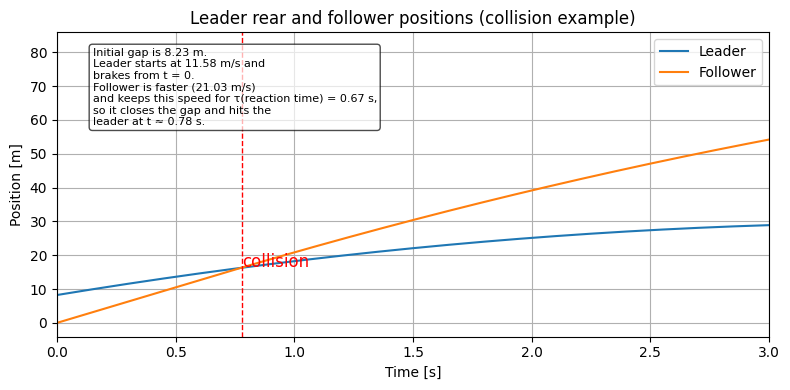

In [722]:
fig, ax = plt.subplots()

ax.plot(t, x_l - sl, label="Leader")
ax.plot(t, x_f,      label="Follower")


if collision and t_coll is not None:
    idx_coll = np.where(gap <= 0)[0][0]
    t_c = t[idx_coll]

    ax.axvline(t_c, linestyle="--", color="red", linewidth=1)
    ax.text(t_c, x_f[idx_coll],
            "collision", fontsize=12, color="red")

text_box = (
    "Initial gap is 8.23 m.\n"
    "Leader starts at 11.58 m/s and\n"
    "brakes from t = 0.\n"
    "Follower is faster (21.03 m/s)\n"
    "and keeps this speed for τ(reaction time) = 0.67 s,\n"
    "so it closes the gap and hits the\n"
    "leader at t ≈ 0.78 s."
)

ax.text(0.05, 0.95, text_box,
        transform=ax.transAxes,
        fontsize=8, va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

ax.set_xlim(0, 3.0)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [m]")
ax.set_title("Leader rear and follower positions (collision example)")
ax.legend()
plt.tight_layout()
plt.show()